<a href="https://colab.research.google.com/github/micah-shull/Data_Analysis/blob/main/DataClean_0_OutlierDetectionRemoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning and Preprocessing - Outliers

### Outliers: Description and Impact on Datasets and Machine Learning

**Outliers** are data points that differ significantly from the majority of observations in a dataset. They can be unusually high or low values and often deviate markedly from the rest of the data. Outliers can arise due to variability in the data, measurement errors, or experimental errors.

### How Outliers Affect Datasets and Machine Learning

1. **Distortion of Statistical Measures:**
   - **Mean and Standard Deviation:** Outliers can skew the mean, making it unrepresentative of the central tendency. They also inflate the standard deviation, indicating more variability than actually exists.
   - **Correlations:** Outliers can distort correlation coefficients, making relationships between variables appear stronger or weaker than they are.

2. **Impact on Data Visualization:**
   - **Graphs and Charts:** Outliers can create misleading visualizations, such as stretched boxplots or scatter plots with points far removed from the bulk of the data, which can obscure the true data patterns.

3. **Effect on Machine Learning Models:**
   - **Linear Models:** Outliers can disproportionately influence linear regression models, leading to biased coefficients and poor model performance.
   - **Distance-Based Models:** Models like k-Nearest Neighbors (k-NN) and clustering algorithms can be heavily impacted by outliers, as they rely on distance calculations.
   - **Tree-Based Models:** While tree-based models (e.g., Random Forests) are generally more robust to outliers, extreme values can still affect the model's performance and interpretation.

4. **Model Training and Evaluation:**
   - **Overfitting:** Outliers can cause models to overfit the training data, learning the noise instead of the signal, which reduces generalizability to new data.
   - **Error Metrics:** Outliers can skew error metrics like Mean Squared Error (MSE) and Root Mean Squared Error (RMSE), making it harder to assess the model's true performance.

5. **Data Integrity and Quality:**
   - **Data Cleaning:** The presence of outliers can indicate issues with data collection or entry, prompting a need for data cleaning to improve data quality.
   - **Decision Making:** Outliers can lead to incorrect insights and decisions if not properly addressed, as they can misrepresent the underlying patterns in the data.

### Strategies to Handle Outliers

To mitigate the negative effects of outliers, various strategies can be employed:

- **Detection and Removal:** Identify and remove outliers to prevent them from distorting the analysis and model training.
- **Transformation:** Apply transformations (e.g., log, Box-Cox) to reduce the impact of outliers.
- **Robust Methods:** Use robust statistical techniques and algorithms (e.g., median, IQR-based methods, robust scaling) that are less sensitive to outliers.
- **Model-Based Detection:** Use advanced methods like Isolation Forest, Local Outlier Factor (LOF), or clustering-based approaches to detect and handle outliers.

By understanding and addressing outliers, you can improve the integrity of your dataset and the performance of your machine learning models.

In [88]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing


# Load the California Housing dataset
california = fetch_california_housing()

# Create a DataFrame
df = pd.DataFrame(california.data, columns=california.feature_names)
df['MedHouseVal'] = california.target

### Visualize Outliers

In [89]:
def visualize_outliers(outliers_dict, df, orient='h', palette='coolwarm', figsize_multiplier=0.5):
    """
    Visualizes the distribution of columns with outliers in a standardized form using boxplots.

    Args:
        outliers_dict (dict): Dictionary containing DataFrames of outliers for each numeric column.
        df (pd.DataFrame): The original DataFrame from which outliers were detected.
        orient (str): Orientation of the boxplot, 'h' for horizontal or 'v' for vertical.
        palette (str): Color palette for the boxplots.
        figsize_multiplier (float): Multiplier to adjust the figure size dynamically based on the number of columns.

    Returns:
        None
    """
    outlier_cols = list(outliers_dict.keys())

    if not outlier_cols:
        print("No outliers detected in numeric columns.")
        return

    # Visualization
    outlier_data_subset = df[outlier_cols].copy()
    std = outlier_data_subset.std()
    mean = outlier_data_subset.mean()
    outlier_data_subset = outlier_data_subset.subtract(mean, axis=1).div(std.replace(0, np.nan), axis=1)

    sns.set_style("whitegrid")
    sns.set_context("notebook")
    plt.figure(figsize=(10, max(1, len(outlier_cols)) * figsize_multiplier))
    sns.boxplot(data=outlier_data_subset, orient=orient, palette=palette)
    plt.title("Boxplot of Features with Outliers (Standardized Data)")
    plt.show()


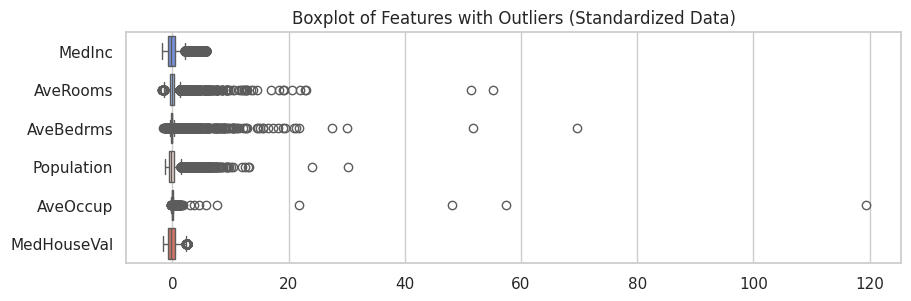

In [90]:
visualize_outliers(outliers_dict, dfc, orient='h', palette='coolwarm', figsize_multiplier=0.5)

## Outlier Detection IQR vs Z Score

### Z-Score Method

The Z-score measures how many standard deviations a data point is from the mean:

\[ Z = \frac{(X - \mu)}{\sigma} \]

#### Strengths:
- **Standardization:** Compares values across different datasets.
- **Simplicity:** Easy to calculate and understand.
- **Effective for Normal Distributions:** Best with normally distributed data.

#### Weaknesses:
- **Sensitive to Outliers:** Mean and standard deviation are influenced by extreme values.
- **Assumes Normality:** Requires data to be normally distributed.

In [91]:
from scipy.stats import zscore

def identify_outliers_zscore(df, threshold=3):
    """
    Identifies outliers in each numeric column of the DataFrame using the Z-score method.

    Args:
        df (pd.DataFrame): The original DataFrame from which outliers are to be detected.
        threshold (float): The Z-score threshold for defining outliers (default is 3).

    Returns:
        dict: Dictionary containing DataFrames of outliers for each numeric column.
    """
    outliers_dict = {}
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        z_scores = zscore(df[col])
        outliers = df[(z_scores > threshold) | (z_scores < -threshold)]
        if not outliers.empty:
            outliers_dict[col] = outliers

    return outliers_dict


In [92]:
dfc = df.copy()
outliers_dict = identify_outliers_zscore(dfc)
print(outliers_dict.keys())

dict_keys(['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup'])




### Interquartile Range (IQR) Method

#### Strengths:
- **Robust to Outliers:** Less affected by extreme values.
- **Distribution-Agnostic:** No assumption of normal distribution.
- **Simple Calculation:** Easy to compute and interpret.

#### Weaknesses:
- **Ignores Extremes:** Focuses only on the middle 50% of data.
- **Less Effective for Small Datasets:** Quartiles might not be well-defined.



In [93]:
def identify_outliers_iqr(df, threshold=1.5):
    """
    Identifies outliers in each numeric column of the DataFrame using the IQR method.

    Args:
        df (pd.DataFrame): The original DataFrame from which outliers are to be detected.
        threshold (float): The IQR multiplier for defining outliers (default is 1.5).

    Returns:
        dict: Dictionary containing DataFrames of outliers for each numeric column.
    """
    outliers_dict = {}
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        if IQR == 0:
            continue  # Skip columns with IQR of 0 (constant values)
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if not outliers.empty:
            outliers_dict[col] = outliers

    return outliers_dict


In [94]:
# apply outlier detection
dfc = df.copy()
outliers_dict = identify_outliers_iqr(dfc)
print(outliers_dict.keys())

dict_keys(['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'MedHouseVal'])


### Differences Between Z-Score and IQR Methods

1. **Calculation Basis:**
   - **Z-Score:** Based on mean and standard deviation.
   - **IQR:** Based on quartiles (median and percentiles).

2. **Sensitivity to Outliers:**
   - **Z-Score:** Sensitive to outliers.
   - **IQR:** Robust to outliers.

3. **Assumption of Distribution:**
   - **Z-Score:** Assumes normal distribution.
   - **IQR:** No distribution assumption.

4. **Application:**
   - **Z-Score:** Standardizing data, normally distributed datasets.
   - **IQR:** Detecting outliers in non-normal data, robust analysis.




### Summary

- **Z-Score:** Standardizes values, effective for normal data but sensitive to outliers.
- **IQR:** Robust to outliers, no distribution assumption, but may miss certain outliers and be less effective for small datasets.

## Dealing with Outliers

### Isolation Forest

Isolation Forest (IsoForest) is an unsupervised machine learning algorithm used for anomaly detection. It works by isolating observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic behind the Isolation Forest algorithm is that outliers are few and different, and they are easier to isolate compared to normal points.

#### Strengths:
- **Efficient:** The algorithm is linear in the number of data points.
- **Effective:** It often performs well for anomaly detection tasks because of its ability to isolate anomalies quickly.
- **Scalability:** Can be applied to large datasets efficiently.
- **No Assumptions:** Does not assume any underlying distribution for the data.

#### Weaknesses:
- **Parameter Sensitivity:** Performance can be sensitive to the number of trees and sub-sample size parameters.
- **Interpretability:** Results can sometimes be less interpretable compared to other methods like statistical methods.

In [95]:
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import seaborn as sns

def handle_outliers_isolation_forest(df, contamination=0.01, random_state=0):
    """
    Identifies and handles outliers in the DataFrame using the Isolation Forest algorithm.

    Args:
        df (pd.DataFrame): The original DataFrame from which outliers are to be detected.
        contamination (float): The proportion of outliers in the data set.
        random_state (int): The seed used by the random number generator.

    Returns:
        pd.DataFrame: The DataFrame with outliers handled.
        pd.Series: A boolean series indicating whether each point is an outlier.
    """
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_numeric = df[numeric_cols]

    # Train the Isolation Forest model
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
    df['outlier'] = iso_forest.fit_predict(df_numeric)

    # -1 indicates an outlier, we will filter them out
    is_inlier = df['outlier'] != -1

    # Drop the outlier column and return the cleaned DataFrame and the boolean series
    df_cleaned = df.drop(columns=['outlier'])
    return df_cleaned[is_inlier], df['outlier']

In [96]:
dfc = df.copy()

print("Number of rows in dataframe before processing =", dfc.shape)
# Handle outliers using Isolation Forest
df_cleaned, outliers = handle_outliers_isolation_forest(dfc)

# Check the results
print('Number of outliers detected:', sum(outliers == -1))
print('Number of inliers:', sum(outliers != -1))
print("Number of rows in dataframe after processing =", df_cleaned.shape)

Number of rows in dataframe before processing = (20640, 9)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Number of outliers detected: 207
Number of inliers: 20433
Number of rows in dataframe after processing = (20433, 9)


### Local Outlier Factor (LOF)

Local Outlier Factor (LOF) is an unsupervised outlier detection algorithm that measures the local density deviation of a given data point with respect to its neighbors. It considers the local density of the neighborhood and compares it with the density of the point itself. Points with a significantly lower density than their neighbors are considered outliers.

#### Strengths:
- **Local Density-Based:** LOF is effective at identifying outliers that are sparse within local clusters.
- **Scalable:** Can handle large datasets efficiently.
- **No Assumptions:** Does not assume any underlying distribution for the data.

#### Weaknesses:
- **Parameter Sensitivity:** Performance can be sensitive to the choice of the number of neighbors (k).
- **Computational Cost:** Can be computationally expensive for very large datasets due to the need to calculate distances between points.




In [97]:
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import pandas as pd
import seaborn as sns

def handle_outliers_lof(df, n_neighbors=20, contamination=0.01):
    """
    Identifies and handles outliers in the DataFrame using the Local Outlier Factor algorithm.

    Args:
        df (pd.DataFrame): The original DataFrame from which outliers are to be detected.
        n_neighbors (int): The number of neighbors to use for the LOF calculation.
        contamination (float): The proportion of outliers in the data set.

    Returns:
        pd.DataFrame: The DataFrame with outliers handled.
        pd.Series: A boolean series indicating whether each point is an outlier.
    """
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_numeric = df[numeric_cols]

    # Train the Local Outlier Factor model
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    df['outlier'] = lof.fit_predict(df_numeric)

    # -1 indicates an outlier, we will filter them out
    is_inlier = df['outlier'] != -1

    # Drop the outlier column and return the cleaned DataFrame and the boolean series
    df_cleaned = df.drop(columns=['outlier'])
    return df_cleaned[is_inlier], df['outlier']

In [98]:
dfc = df.copy()
print("Number of rows in dataframe before processing =", dfc.shape)

# Handle outliers using Local Outlier Factor
df_cleaned, outliers = handle_outliers_lof(dfc)

# Check the results
print('Number of outliers detected:', sum(outliers == -1))
print('Number of inliers:', sum(outliers != -1))
print("Number of rows in dataframe after processing =", df_cleaned.shape)

Number of rows in dataframe before processing = (20640, 9)
Number of outliers detected: 207
Number of inliers: 20433
Number of rows in dataframe after processing = (20433, 9)


### Log Transformation

Log transformation is a technique used to stabilize variance, make the data more normally distributed, and reduce the skewness of the data. It is particularly useful when dealing with data that spans several orders of magnitude. The log transformation is defined as the natural logarithm (ln) of the data.

#### Strengths:
- **Reduces Skewness:** Helps in reducing the skewness of the data, making it more normally distributed.
- **Stabilizes Variance:** Reduces heteroscedasticity (when the variance of the data is unequal across the range of values).
- **Highlights Small Changes:** Makes it easier to see small changes in data that have a large range.

#### Weaknesses:
- **Non-Negative Values Required:** Log transformation can only be applied to positive values. Zero or negative values need to be handled separately.
- **Interpretation:** Transformed data may be harder to interpret compared to the original scale.





In [99]:
import numpy as np
import pandas as pd
import seaborn as sns

def apply_log_transform(df):
    """
    Applies log transformation to numerical columns in the DataFrame.

    Args:
        df (pd.DataFrame): The original DataFrame to be transformed.

    Returns:
        pd.DataFrame: The DataFrame with log-transformed numerical columns.
    """
    df_transformed = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        # Add a small constant to avoid log(0)
        df_transformed[col] = df_transformed[col].apply(lambda x: np.log(x + 1) if x > 0 else np.nan)

    return df_transformed

In [100]:
dfc = df.copy()
print("Number of rows in dataframe before processing =", dfc.shape)
# Apply log transformation
df_log_transformed = apply_log_transform(dfc)
print("Number of rows in dataframe after processing =", df_log_transformed.shape)

Number of rows in dataframe before processing = (20640, 9)
Number of rows in dataframe after processing = (20640, 9)


### Box-Cox Transformation

The Box-Cox transformation is a family of power transformations that aim to stabilize variance and make the data more normally distributed. The Box-Cox transformation is defined for positive data and is parameterized by a lambda value (λ) that can be optimized to best fit the data to a normal distribution.

#### Strengths:
- **Variance Stabilization:** Helps in stabilizing the variance across the dataset.
- **Normality:** Makes the data more normally distributed, which is useful for many statistical techniques that assume normality.
- **Flexibility:** The transformation is flexible and can be adjusted using the lambda parameter to achieve the best normalization effect.

#### Weaknesses:
- **Non-Negative Values Required:** Box-Cox transformation can only be applied to positive data. Zero or negative values need to be handled separately.
- **Complexity:** The process of finding the optimal lambda can be computationally intensive.
- **Interpretation:** Transformed data may be harder to interpret compared to the original scale.


In [101]:
from scipy.stats import boxcox
import numpy as np
import pandas as pd
import seaborn as sns

def apply_box_cox_transform(df):
    """
    Applies Box-Cox transformation to numerical columns in the DataFrame.

    Args:
        df (pd.DataFrame): The original DataFrame to be transformed.

    Returns:
        pd.DataFrame: The DataFrame with Box-Cox transformed numerical columns.
    """
    df_transformed = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        # Only apply Box-Cox transformation to positive values
        if (df_transformed[col] > 0).all():
            df_transformed[col], _ = boxcox(df_transformed[col])
        else:
            # Handle non-positive values separately if needed
            df_transformed[col] = df_transformed[col].apply(lambda x: np.nan if x <= 0 else x)
            df_transformed[col] = df_transformed[col].dropna()
            df_transformed[col], _ = boxcox(df_transformed[col])

    return df_transformed

count    20640.000000
mean      -119.569704
std          2.003532
min       -124.350000
25%       -121.800000
50%       -118.490000
75%       -118.010000
max       -114.310000
Name: Longitude, dtype: float64


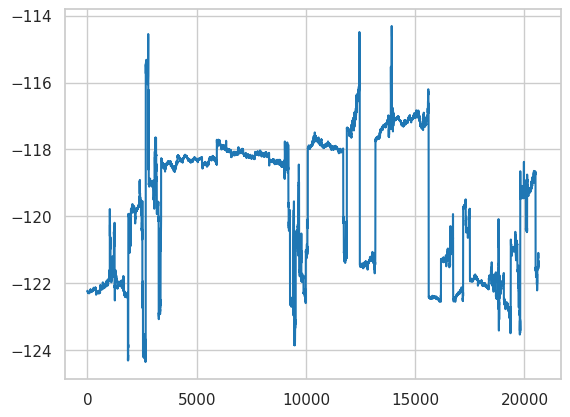

In [104]:
dfc = df.copy()

# negative values are not accepted by this method
dfc['Longitude'].plot()
print(dfc['Longitude'].describe().T)

In [105]:
dfc = df.copy()

dfL = df.drop(columns=['Latitude', 'Longitude'], axis=1)
print("Number of rows in dataframe before processing =", dfL.shape)

# Apply Box-Cox transformation
df_box_cox_transformed = apply_box_cox_transform(dfL)
print("Number of rows in dataframe after processing =", df_box_cox_transformed.shape)

Number of rows in dataframe before processing = (20640, 7)
Number of rows in dataframe after processing = (20640, 7)


### Additional Methods for Handling Outliers

Beyond the Isolation Forest, Local Outlier Factor, and transformation methods like Log and Box-Cox transformations, there are several other effective techniques for detecting and handling outliers. Here are a few more methods:

### 1. **Winsorization**

Winsorization involves limiting extreme values in the data to reduce the effect of possibly spurious outliers. This technique involves setting the extreme values to a certain percentile value, effectively capping them.

#### Strengths:
- **Reduces the Impact of Outliers:** Effectively reduces the influence of extreme values without removing data points.
- **Simple and Easy to Implement:** Easy to apply with clear rules.

#### Weaknesses:
- **Arbitrary Limits:** The choice of percentiles can be arbitrary and might not be optimal for all datasets.

### Implementation of Winsorization

```python
from scipy.stats.mstats import winsorize

def apply_winsorization(df, limits=(0.01, 0.01)):
    """
    Applies Winsorization to numerical columns in the DataFrame.

    Args:
        df (pd.DataFrame): The original DataFrame to be transformed.
        limits (tuple): The lower and upper limits for Winsorization.

    Returns:
        pd.DataFrame: The DataFrame with Winsorized numerical columns.
    """
    df_transformed = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        df_transformed[col] = winsorize(df_transformed[col], limits=limits)

    return df_transformed

# Example usage:
# Load the California Housing dataset
from sklearn.datasets import fetch_california_housing
df_california = fetch_california_housing()

# Create a DataFrame
df_california = pd.DataFrame(df_california.data, columns=df_california.feature_names)
df_california['MedHouseVal'] = df_california.target

# Apply Winsorization
df_winsorized = apply_winsorization(df_california, limits=(0.01, 0.01))

# Check the results
print(df_winsorized.head())
```

### 2. **Robust Scaler**

Robust Scaler scales features using statistics that are robust to outliers. This method uses the median and the interquartile range (IQR) for scaling, which makes it less sensitive to outliers compared to standard scaling methods.

#### Strengths:
- **Resilient to Outliers:** More resilient to outliers than other scaling methods.
- **Normalizes Data:** Helps in normalizing the data for better model performance.

#### Weaknesses:
- **Still Sensitive to Extreme Outliers:** While more robust, it can still be affected by extreme outliers.

### Implementation of Robust Scaler

```python
from sklearn.preprocessing import RobustScaler

def apply_robust_scaler(df):
    """
    Applies Robust Scaler to numerical columns in the DataFrame.

    Args:
        df (pd.DataFrame): The original DataFrame to be transformed.

    Returns:
        pd.DataFrame: The DataFrame with scaled numerical columns.
    """
    df_transformed = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    scaler = RobustScaler()
    df_transformed[numeric_cols] = scaler.fit_transform(df_transformed[numeric_cols])

    return df_transformed

# Example usage:
# Load the California Housing dataset
from sklearn.datasets import fetch_california_housing
df_california = fetch_california_housing()

# Create a DataFrame
df_california = pd.DataFrame(df_california.data, columns=df_california.feature_names)
df_california['MedHouseVal'] = df_california.target

# Apply Robust Scaler
df_robust_scaled = apply_robust_scaler(df_california)

# Check the results
print(df_robust_scaled.head())
```

### 3. **Clipping**

Clipping is a simple method where values outside a certain range are set to the boundary values of that range. This method is similar to Winsorization but typically applied with fixed boundaries.

#### Strengths:
- **Simple to Implement:** Easy to apply with predefined boundaries.
- **Reduces the Impact of Extreme Values:** Limits the influence of outliers.

#### Weaknesses:
- **Arbitrary Limits:** The choice of boundaries can be arbitrary and might not suit all datasets.

### Implementation of Clipping

```python
def apply_clipping(df, lower_percentile=0.01, upper_percentile=0.99):
    """
    Applies clipping to numerical columns in the DataFrame.

    Args:
        df (pd.DataFrame): The original DataFrame to be transformed.
        lower_percentile (float): The lower percentile for clipping.
        upper_percentile (float): The upper percentile for clipping.

    Returns:
        pd.DataFrame: The DataFrame with clipped numerical columns.
    """
    df_transformed = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        lower_bound = df_transformed[col].quantile(lower_percentile)
        upper_bound = df_transformed[col].quantile(upper_percentile)
        df_transformed[col] = df_transformed[col].clip(lower=lower_bound, upper=upper_bound)

    return df_transformed

# Example usage:
# Load the California Housing dataset
from sklearn.datasets import fetch_california_housing
df_california = fetch_california_housing()

# Create a DataFrame
df_california = pd.DataFrame(df_california.data, columns=df_california.feature_names)
df_california['MedHouseVal'] = df_california.target

# Apply Clipping
df_clipped = apply_clipping(df_california, lower_percentile=0.01, upper_percentile=0.99)

# Check the results
print(df_clipped.head())
```

### Summary

- **Winsorization:** Caps extreme values to reduce the impact of outliers.
- **Robust Scaler:** Scales data using robust statistics, making it less sensitive to outliers.
- **Clipping:** Sets values outside a certain range to boundary values.

These methods provide additional tools for handling outliers in your dataset, each with its strengths and weaknesses.